# Dota classifier notebook

## Imports and setup

In [17]:
# Imports
import os
import gc
import numpy as np
import time
import shutil
import random
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from itertools import repeat
import gc   #garbage collector
import pickle
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
# load the model
from keras.models import load_model
from PIL import Image
from keras import optimizers

import web_scraping

import matplotlib.pyplot as plt
%matplotlib inline


scrape_heroes = False

In [2]:
# from tensorflow.python.client import device_lib

# device_lib.list_local_devices()

## Scraping heroes and images

In [3]:
# get list of heroes
if scrape_heroes == True:
    heroes = web_scraping.scrapeheroes(url = 'https://dota2.gamepedia.com/Heroes_by_release')

In [4]:
# scrape images if needed
if scrape_heroes == True:
    web_scraping.scrape_hero_images(heroes)

In [5]:
# check for files that wouldnt get preprocessed and delete them (some problems with PIL Image later)
if scrape_heroes == True:
    for dataset in data_dir_list[0:n_heroes]:
        img_list=os.listdir(PATH + '/hero_images/validation' + '/'+ dataset)
        
        for img in img_list:
            try:
                img_path = PATH + '/hero_images/validation' + '/'+ dataset + '/'+ img
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
            except:
                print(data_path + '/'+ dataset + '/'+ img)
        print ('Checked images of dataset - '+'{}'.format(dataset))

In [6]:
# move some files to validation
if scrape_heroes == True:
    
    # get current path
    PATH = os.getcwd()
    # Define data path
    data_path = PATH + '/hero_images/train'
    data_dir_list = os.listdir(data_path)
    
    n_heroes = len(data_dir_list)
    num_classes = len(data_dir_list[0:n_heroes])
    
    n_validation = 10
    for dataset in data_dir_list[0:n_heroes]:
        hero_path = PATH + '\\hero_images\\train\\'+ dataset
        for i in range(n_validation):
            random_file = random.choice(os.listdir(hero_path))
            shutil.move(hero_path +'\\'+ random_file,
                        PATH + '\\hero_images\\validation\\'+ dataset +'\\'+ random_file)
            

In [7]:
# convert all files to jpg and resize them
if scrape_heroes == True:
    basewidth = 500
    for dataset in data_dir_list[0:n_heroes]:
        img_list=os.listdir(data_path+'\\'+ dataset)
        for img in img_list:
            img_path = data_path+'\\'+ dataset+'\\'+ img
            im = Image.open(img_path)
            wpercent = (basewidth/float(im.size[0]))
            hsize = int((float(im.size[1])*float(wpercent)))
            im = im.resize((basewidth,hsize), Image.ANTIALIAS)
            rgb_im = im.convert('RGB')
            rgb_im.save(os.path.splitext(img_path)[0] +"_converted.jpg")
            os.remove(img_path)

In [8]:
# convert all files to jpg and resize them
if scrape_heroes == True:
    basewidth = 500
    for dataset in data_dir_list[0:n_heroes]:
        img_list=os.listdir( PATH + '\\hero_images\\validation'+'\\'+ dataset)
        for img in img_list:
            img_path = PATH + '\\hero_images\\validation'+'\\'+ dataset+'\\'+ img
            im = Image.open(img_path)
            wpercent = (basewidth/float(im.size[0]))
            hsize = int((float(im.size[1])*float(wpercent)))
            im = im.resize((basewidth,hsize), Image.ANTIALIAS)
            rgb_im = im.convert('RGB')
            rgb_im.save(os.path.splitext(img_path)[0] +"_converted.jpg")
            os.remove(img_path)

In [9]:
# convert 1 image for each hero to JPG and to certain width for displaying in the app
if scrape_heroes == True:
    web_scraping.convert_images(300,data_path,data_dir_list,n_heroes)

In [32]:
# get current path
PATH = os.getcwd()
# Define data path
data_path = PATH + '/hero_images/train'
data_dir_list = os.listdir(data_path)

n_heroes = len(data_dir_list)
num_classes = len(data_dir_list[0:n_heroes])
pickle.dump( data_dir_list, open( "labels.p", "wb" ) )

## Preprocessing of images and modelling

In [11]:
batch_size = 16

# BE CAREFUL TO PUT PREPROCESS INPUT LAST. OTHERWISE THE TRAINING DOESNT WORK PROPERLY
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        
#        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_input)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
#    ,rescale=1./255
)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'hero_images/train',  # this is the target directory
        target_size=(299, 299),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical') 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'hero_images/validation',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')

predict_generator = test_datagen.flow_from_directory(
        'hero_images/predict',
        target_size=(299, 299),
        batch_size=1,
        class_mode='categorical')

Found 8417 images belonging to 117 classes.
Found 1170 images belonging to 117 classes.
Found 10 images belonging to 1 classes.


In [12]:
model = InceptionV3(include_top=True,weights='imagenet')


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
# model.summary()
last_layer = model.get_layer('avg_pool').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_inception_model = Model(model.input, out)
#custom_inception_model.summary()

for layer in custom_inception_model.layers[:-1]:
    layer.trainable = False

custom_inception_model.layers[3].trainable


False

In [24]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [25]:
#custom_inception_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
custom_inception_model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [26]:
history = custom_inception_model.fit_generator(
  train_generator,
  steps_per_epoch=600,
  epochs=10,
  validation_data=validation_generator,
  validation_steps=30,
  class_weight='auto')

Epoch 1/10
600/600 [==============================] - 371s 619ms/step - loss: 4.4971 - acc: 0.0741 - val_loss: 4.4863 - val_acc: 0.0833
Epoch 2/10
600/600 [==============================] - 366s 611ms/step - loss: 4.3600 - acc: 0.1023 - val_loss: 4.3633 - val_acc: 0.1042
Epoch 3/10
600/600 [==============================] - 369s 615ms/step - loss: 4.2163 - acc: 0.1364 - val_loss: 4.2517 - val_acc: 0.1271
Epoch 4/10
600/600 [==============================] - 368s 614ms/step - loss: 4.1051 - acc: 0.1649 - val_loss: 4.1643 - val_acc: 0.1521
Epoch 5/10
600/600 [==============================] - 369s 615ms/step - loss: 3.9980 - acc: 0.1790 - val_loss: 4.0939 - val_acc: 0.1604
Epoch 6/10
600/600 [==============================] - 370s 617ms/step - loss: 3.9016 - acc: 0.2056 - val_loss: 4.0029 - val_acc: 0.1938
Epoch 7/10
600/600 [==============================] - 372s 621ms/step - loss: 3.8112 - acc: 0.2214 - val_loss: 3.9437 - val_acc: 0.2000
Epoch 8/10
600/600 [============================

In [27]:
custom_inception_model.save('inception_model_not_scaled.h5')

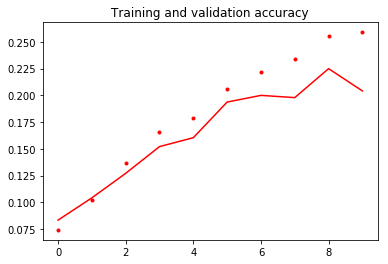

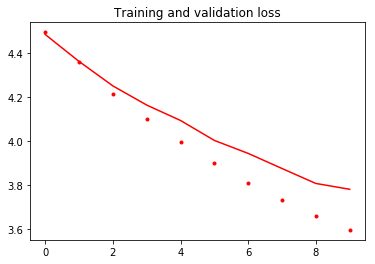

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r.')
plt.plot(epochs, val_acc, 'r')
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'r.')
plt.plot(epochs, val_loss, 'r-')
plt.title('Training and validation loss')
plt.show()

In [29]:
custom_inception_model = load_model('inception_model_not_scaled.h5')

In [30]:
image_example = load_img('hero_images//train//Abaddon//000025_converted.jpg', target_size=(299, 299))
# convert the image pixels to a numpy array
image_example = img_to_array(image_example)
image_example = np.expand_dims(image_example, axis=0)
# reshape data for the model
# prepare the image for the VGG model
image_example = preprocess_input(image_example)
# predict the probability across all output classes
yhat = custom_inception_model.predict(image_example)
# convert the probabilities to class labels
label = data_dir_list[np.argmax(yhat)]
# retrieve the most likely result, e.g. highest probability
# print the classification
print(label)

Terrorblade


In [31]:
for dataset in data_dir_list[0:7]:
    img_list=os.listdir(data_path+'\\'+ dataset)
    for img in img_list:
        img_path = data_path+'\\'+ dataset+'\\'+ img
        image_example = load_img(img_path, target_size=(299, 299))
        # convert the image pixels to a numpy array
        image_example = img_to_array(image_example)
        image_example = np.expand_dims(image_example, axis=0)
        # reshape data for the model
        # prepare the image for the VGG model
        image_example = preprocess_input(image_example)
        # predict the probability across all output classes
        yhat = custom_inception_model.predict(image_example)
        # convert the probabilities to class labels
        label = data_dir_list[np.argmax(yhat)]
        # retrieve the most likely result, e.g. highest probability
        # print the classification
        print(label,label == dataset)

Spectre False
Phantom Assassin False
Outworld Devourer False
Abaddon True
Abaddon True
Drow Ranger False
Abaddon True
Abaddon True
Abaddon True
Abaddon True
Abaddon True
Abaddon True
Abaddon True
Abaddon True
Abaddon True
Terrorblade False
Abaddon True
Silencer False
Windranger False
Grimstroke False
Abaddon True
Beastmaster False
Abaddon True
Abaddon True
Ursa False
Tinker False
Morphling False
Outworld Devourer False
Abaddon True
Abaddon True
Phantom Lancer False
Terrorblade False
Broodmother False
Abaddon True
Broodmother False
Death Prophet False
Razor False
Abaddon True
Leshrac False
Treant Protector False
Chen False
Abaddon True
Arc Warden False
Abaddon True
Storm Spirit False
Treant Protector False
Abaddon True
Alchemist False
Abaddon True
Abaddon True
Grimstroke False
Underlord False
Terrorblade False
Spectre False
Broodmother False
Abaddon True
Razor False
Abaddon True
Necrophos False
Abaddon True
Nyx Assassin False
Ancient Apparition False
Razor False
Mirana False
Broodmother

In [ ]:
with open('labels.p', 'rb') as f:
    data_dir_list = pickle.load(f)

In [ ]:
# Test model on an example
# load model
custom_inception_model = load_model('my_model2.h5')
# load an image from file
image_example = load_img('tom3.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image_example = img_to_array(image_example)
# reshape data for the model
image_example = image_example.reshape((1, image_example.shape[0], image_example.shape[1], image_example.shape[2]))
# prepare the image for the VGG model
image_example = preprocess_input(image_example)
# predict the probability across all output classes
yhat = custom_vgg_model.predict(image_example)
# convert the probabilities to class labels
label = data_dir_list[np.argmax(yhat)]
# retrieve the most likely result, e.g. highest probability
# print the classification
print(label)